In [1]:
#Importing required Libraries
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# Read csv files into a pandas dataframe
#Twitter archive data
tw_archive = pd.read_csv('twitter-archive-enhanced.csv')
#Image predictions data
img_pre = pd.read_csv("image_predictions.tsv", sep = "\t")

In [3]:
# extract data from Twitter API data (tweet_json.txt), convert to data frame with tweets id , retweet_count and favorite_count
tweets_list = []
with open('tweet-json.txt' , 'r') as file:
    for lines in file:
        tweet = json.loads(lines)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        tweets_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
tweets_list
tweets = pd.DataFrame(tweets_list)

#### 1.Twitter archive data

In [4]:
#display first 5 rows in Twitter archive data
tw_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
#select the most interesting columns from dataset
interesting_columns = ['tweet_id','timestamp','source', 'text', 'rating_numerator',
      'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'
]
tw_archive = pd.DataFrame(tw_archive, columns=interesting_columns)

In [6]:
#check the dataset features types and shape
tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   rating_numerator    2356 non-null   int64 
 5   rating_denominator  2356 non-null   int64 
 6   name                2356 non-null   object
 7   doggo               2356 non-null   object
 8   floofer             2356 non-null   object
 9   pupper              2356 non-null   object
 10  puppo               2356 non-null   object
dtypes: int64(3), object(8)
memory usage: 202.6+ KB


In [7]:
# Number of unique values in Features 
tw_archive.nunique()

tweet_id              2356
timestamp             2356
source                   4
text                  2356
rating_numerator        40
rating_denominator      18
name                   957
doggo                    2
floofer                  2
pupper                   2
puppo                    2
dtype: int64

In [8]:
#check the values in categorical columns
for column in tw_archive[['source','doggo', 'floofer', 'pupper', 'puppo']]:
    print(f'{column}:\n{tw_archive[column].value_counts()}')

source:
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64
doggo:
None     2259
doggo      97
Name: doggo, dtype: int64
floofer:
None       2346
floofer      10
Name: floofer, dtype: int64
pupper:
None      2099
pupper     257
Name: pupper, dtype: int64
puppo:
None     2326
puppo      30
Name: puppo, dtype: int64


In [9]:
#Any duplicated rows ?
tw_archive.duplicated().sum()

0

#### Assessing Twitter archive data results

1. timestamp is stored as object , it should stored as datetime
2. extract sources from links 
3. extract dogs stage from text, then drop doggo, floofer, pupper and puppo columns
4. the fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.



In [10]:
#Extract text from source column
tw_archive['source'] = [BeautifulSoup(X).getText() for X in tw_archive['source']]
#replace 'None' and 'a' to nan
tw_archive['name'] = tw_archive['name'].replace({'None': 'Unknown' , 'a' : 'Unknown'})
tw_archive['name'] = tw_archive['name'].str.lower()
#Extract dogs stage names from text
tw_archive['dogs_stage'] = tw_archive['text'].str.extract('(puppo|pupper|floofer|doggo|Puppo|Pupper|Floofer|Doggo)')
tw_archive['dogs_stage'] = tw_archive['dogs_stage'].str.lower()

In [11]:
#change timestamp datatype to pandas datetime 
tw_archive['timestamp'] = pd.to_datetime(tw_archive['timestamp']).values.astype('<M8[m]')
tw_archive.timestamp.min(),tw_archive.timestamp.max()

(Timestamp('2015-11-15 22:32:00'), Timestamp('2017-08-01 16:23:00'))

In [12]:
#create column for tweet date
tw_archive['date'] = tw_archive['timestamp'].dt.date
#create column for tweet time
tw_archive['time']=tw_archive['timestamp'].dt.time
#create column for tweet day
tw_archive['day'] = tw_archive['timestamp'].dt.day_name()
#create column for tweet year
tw_archive['year'] = tw_archive['timestamp'].dt.year
#create column for tweet month
tw_archive['month'] = tw_archive['timestamp'].dt.month_name()

In [13]:
#drop columns with too many missing values and not useful in analysis 
tw_archive = tw_archive.drop(columns=['doggo', 'floofer', 'pupper', 'puppo','timestamp'] , axis=1)

In [14]:
#check changes
tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   source              2356 non-null   object
 2   text                2356 non-null   object
 3   rating_numerator    2356 non-null   int64 
 4   rating_denominator  2356 non-null   int64 
 5   name                2356 non-null   object
 6   dogs_stage          418 non-null    object
 7   date                2356 non-null   object
 8   time                2356 non-null   object
 9   day                 2356 non-null   object
 10  year                2356 non-null   int64 
 11  month               2356 non-null   object
dtypes: int64(4), object(8)
memory usage: 221.0+ KB


#### 2. Image predictions data

In [17]:
#display first 5 rows in dataset
img_pre.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
#check the dataset features types and shape
img_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# Number of unique values in Features 
img_pre.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [20]:
#descriptive statistics for dataset
img_pre.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [82]:
#Any duplicated rows ?
img_pre.duplicated().sum()

0

#### Assessing Image predictions data results
1. p1_cof always has the highest confidence percentage than p2_cof and p3_cof
2. creat two columns 'confidence' and 'dog_breed' with confidence percentage refer to dog breed


In [21]:
#create columns for dog breed from prediction and its confidence
breed = []
confidence= []
for index, rows in img_pre.iterrows():
    if rows['p1_dog'] == True :
        breed.append(rows['p1'])
        confidence.append(int(rows['p1_conf']*100))
    else :
        if rows['p2_dog'] == True:
            breed.append(rows['p2'])
            confidence.append(int(rows['p2_conf']*100))
        else :
            if rows['p3_dog'] == True:
                breed.append(rows['p3'])
                confidence.append(int(rows['p3_conf']*100))
            else :
                breed.append(np.nan)
                confidence.append(np.nan)
                
img_pre['confidence %'] = confidence
img_pre['confidence %'] = img_pre['confidence %'].astype('Int64')
img_pre['dog_breed'] = breed
img_pre['dog_breed'] = img_pre['dog_breed'].str.lower()

In [22]:
#drop columns with too many missing values and not useful in analysis 
img_pre = img_pre.drop(columns=['p1','p2','p3','p1_conf','p2_conf','img_num','p3_conf','p1_dog','p2_dog','p3_dog'] , axis=1)

In [23]:
#check changes
img_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_id      2075 non-null   int64 
 1   jpg_url       2075 non-null   object
 2   confidence %  1751 non-null   Int64 
 3   dog_breed     1751 non-null   object
dtypes: Int64(1), int64(1), object(2)
memory usage: 67.0+ KB


#### 3. Tweets API data

In [24]:
#display the first 5 rows of Twitter API data
tweets.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [25]:
#check the dataset features types and shape
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [26]:
#descriptive statistics for dataset
tweets.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [27]:
#Any duplicated rows ?
tweets.duplicated().sum()

0

In [28]:
#merge 3 datasets to twitter_archive_master
master = pd.merge(tw_archive, tweets,  on='tweet_id')
master = pd.merge(master, img_pre , on = 'tweet_id')
master.to_csv('twitter_archive_master.csv')
master.head()


,tweet_id,source,text,rating_numerator,rating_denominator,name,dogs_stage,date,time,day,year,month,retweet_count,favorite_count,jpg_url,confidence %,dog_breed
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,phineas,NaN,2017-08-01,16:23:00,Tuesday,2017,August,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,<NA>,NaN
1,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,tilly,NaN,2017-08-01,00:17:00,Tuesday,2017,August,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,32,chihuahua
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,archie,NaN,2017-07-31,00:18:00,Monday,2017,July,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,71,chihuahua
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,darla,NaN,2017-07-30,15:58:00,Sunday,2017,July,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,16,labrador_retriever
4,891327558926688256,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,franklin,NaN,2017-07-29,16:00:00,Saturday,2017,July,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,55,basset


In [29]:
#check changes
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2073 non-null   int64 
 1   source              2073 non-null   object
 2   text                2073 non-null   object
 3   rating_numerator    2073 non-null   int64 
 4   rating_denominator  2073 non-null   int64 
 5   name                2073 non-null   object
 6   dogs_stage          353 non-null    object
 7   date                2073 non-null   object
 8   time                2073 non-null   object
 9   day                 2073 non-null   object
 10  year                2073 non-null   int64 
 11  month               2073 non-null   object
 12  retweet_count       2073 non-null   int64 
 13  favorite_count      2073 non-null   int64 
 14  jpg_url             2073 non-null   object
 15  confidence %        1750 non-null   Int64 
 16  dog_breed           1750

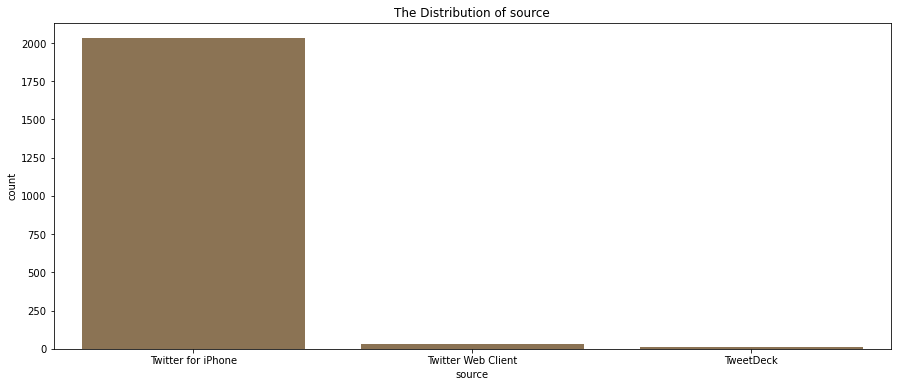

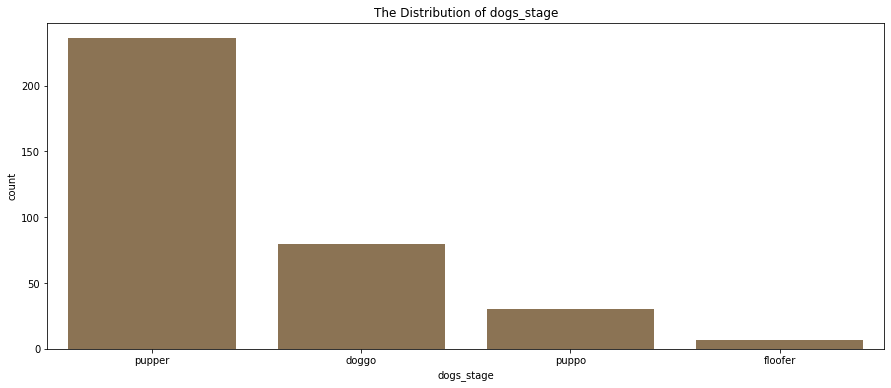

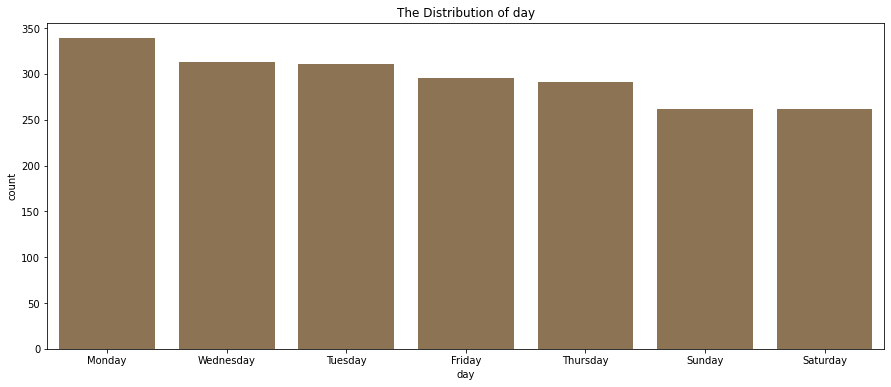

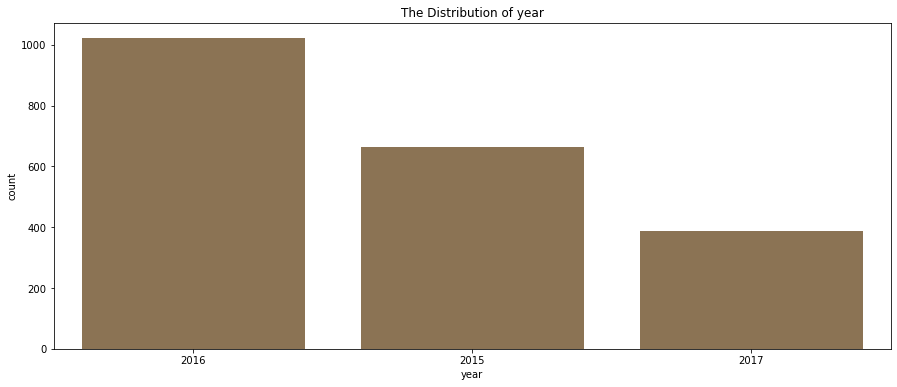

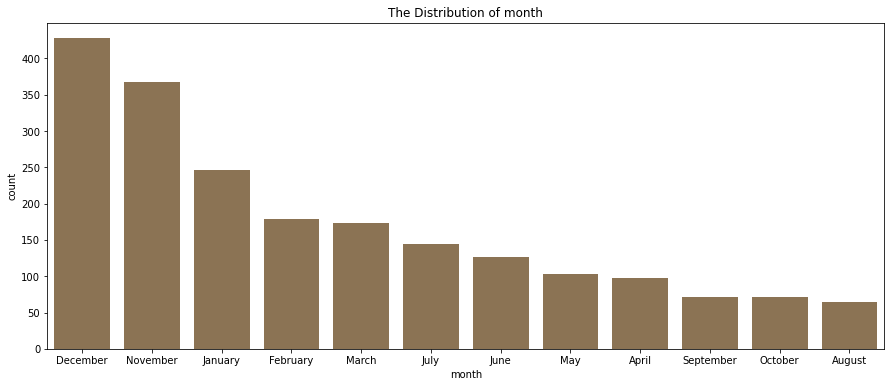

In [40]:
#the distribution of categ columns 
for column in master[['source', 'dogs_stage', 'day', 'year', 'month']]:
    plt.figure(figsize = [15, 6])
    sns.countplot(master[column],order = master[column].value_counts().index , color='#94744B');
    plt.title('The Distribution of '+column);
    plt.show()

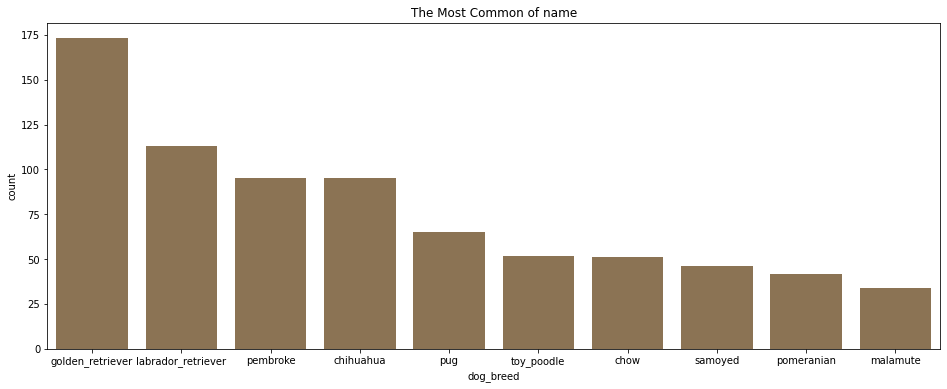

In [84]:
#the most common dog breeds 
plt.figure(figsize = [16, 6])
sns.countplot(master['dog_breed'],order = master['dog_breed'].value_counts()[:10].index , color='#94744B');
plt.title('The Most Common of '+column);
plt.show()

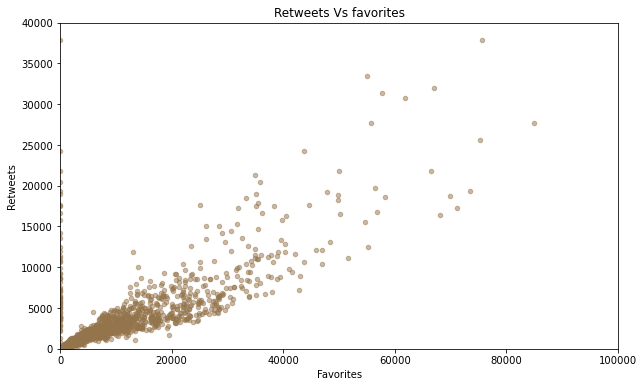

In [95]:
# favorite_count and retweet_count
plt.rcParams['figure.figsize']=(10,6)
master.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', alpha = 0.5, color = '#94744B')
plt.xlim((0,100000))
plt.ylim((0,40000))
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets Vs favorites');